<b> Import Library, find available devices </b>

In [1]:
# Initialization code for Beta Multiplier Reference Testing.
# This block identifies and initializes the connected SMUs (Source Measure Units).
# If running for the first time, ensure the SMU names are correctly referenced in the subsequent code block.

# This program (ENTER DESCRIPTION)
# This program 
# This program creates a .csv file to save the measurements.

# The setup assumes the use of three SMUs:
# - 
# - 

import pyvisa                    # Importing the pyvisa library for instrument communication
import time                      # Importing the time module to handle time-related tasks (e.g., delays)
import matplotlib.pyplot as plt  # Importing matplotlib.pyplot for plotting graphs and visualizing data
import numpy as np               # Importing numpy for numerical operations, particularly with arrays
import pandas as dp              # Importing pandas as dp for data manipulation and analysis
import os                        # Importing os to interact with the operating system, such as handling file paths
import csv                       # Importing csv to read from and write to CSV files
from datetime import date           # Importing date to read current date
rm = pyvisa.ResourceManager()    # Create a ResourceManager object, which manages communication with instruments
rm.list_resources()              # List all available resources (e.g., connected instruments) managed by pyvisa

('USB0::0x2A8D::0x0101::MY54505624::INSTR',
 'USB0::0x2A8D::0x0101::MY57508183::INSTR',
 'GPIB6::6::INSTR',
 'GPIB6::20::INSTR',
 'GPIB6::21::INSTR',
 'USB0::0x0957::0x0607::MY45002108::0::INSTR',
 'USB0::0x0957::0x1796::MY57231548::0::INSTR',
 'USB0::0x0957::0x1796::MY57231553::0::INSTR',
 'USB0::0x0957::0x17B6::MY56310504::0::INSTR',
 'USB0::0x0957::0x2C07::MY57890777::0::INSTR',
 'USB0::0x0957::0x5707::MY53802060::0::INSTR')

In [2]:
#Establishing Connection for DUT 1 SMU
SM1 = rm.open_resource('GPIB6::20::INSTR')  # Open a connection to the instrument with the address 'ASRL3::INSTR' and assign it to SM_VIN
SM1.read_termination = '\n'             # Set the read termination character to a newline. This tells pyvisa when to consider a message as complete when reading from the instrument.
SM1.write_termination = '\n'            # Set the write termination character to a newline. This ensures that each command sent to the instrument is properly terminated.
SM1.baud_rate = 9600                    # Set the baud rate for serial communication to 9600. This is the speed at which data is transmitted over the serial connection.
print(SM1)                              # Print the resource object (SM_VIN) to display its properties
print(SM1.query('*IDN?'))               # Send the '*IDN?' command to the instrument and print its response. This command usually asks the instrument to identify itself (e.g., manufacturer, model number).

#Establishing Connection for DUT 2 SMU
SM2 = rm.open_resource('GPIB6::21::INSTR') # Open a connection to the instrument with the address 'ASRL4::INSTR' and assign it to SM_VOUT
SM2.read_termination = '\n'            # Set the read termination character to a newline for SM_VOUT, similar to SM_VIN
SM2.write_termination = '\n'           # Set the write termination character to a newline for SM_VOUT, similar to SM_VIN
SM2.baud_rate = 9600                   # Set the baud rate for SM_VOUT to 9600, ensuring both instruments communicate at the same speed
print(SM2)                             # Print the resource object (SM_VOUT) to display its properties
print(SM2.query('*IDN?'))              # Send the '*IDN?' command to the SM_VOUT instrument and print its response, identifying the instrument


#Establishing Connection for multimeter 1
MM1 = rm.open_resource('USB0::0x2A8D::0x0101::MY54505624::INSTR')
MM1.read_termination = '\n'             # Set the read termination character to a newline. This tells pyvisa when to consider a message as complete when reading from the instrument.
MM1.write_termination = '\n'
MM1.baud_rate = 9600
print(MM1)                             # Print the resource object (SM_VOUT) to display its properties
print(MM1.query('*IDN?'))   

#Establishing Connection for multimeter 2
MM2 = rm.open_resource('USB0::10893::257::MY57508183::0::INSTR')
MM2.read_termination = '\n'             # Set the read termination character to a newline. This tells pyvisa when to consider a message as complete when reading from the instrument.
MM2.write_termination = '\n'
MM2.baud_rate = 9600
print(MM2)                             # Print the resource object (SM_VOUT) to display its properties
print(MM2.query('*IDN?'))   


#Establishing Connection for Temperature Chamber
CHAMBER = rm.open_resource('GPIB6::6::INSTR') 
CHAMBER.read_termination = '\n'            
CHAMBER.write_termination = '\n'           
CHAMBER.baud_rate = 9600                  
print(CHAMBER)                            
print(CHAMBER.query('STATUS?'))              

VDD_MAX=1.2
currentRange = 1e-4
x=np.arange(0, 1.21, 0.01)
TEMPlist = [125, 100, 75, 50, 27, 0, -27, -50, -75, -100, -125, -150, -175]      # List of temperatures for test


GPIBInstrument at GPIB6::20::INSTR
KEITHLEY INSTRUMENTS INC.,MODEL 2401,4636506,B02 Jan 20 2021 10:19:49/B01  /W/N
GPIBInstrument at GPIB6::21::INSTR
KEITHLEY INSTRUMENTS INC.,MODEL 2401,4636504,B02 Jan 20 2021 10:19:49/B01  /W/N
USBInstrument at USB0::0x2A8D::0x0101::MY54505624::0::INSTR
Keysight Technologies,34465A,MY54505624,A.02.14-02.40-02.14-00.49-02-01
USBInstrument at USB0::10893::257::MY57508183::0::INSTR
Keysight Technologies,34465A,MY57508183,A.02.17-02.40-02.17-00.52-04-01
GPIBInstrument at GPIB6::6::INSTR
YNNYYYYNNNNNNNNNNN0


<b> Test Sweep Definitions </b>

In [3]:
def Chamber_INIT():
    CHAMBER.write("ON")
    CHAMBER.write("RATE=20")            # Sets the speed at which the chamber will ramp to change TEMP
    CHAMBER.write("WAIT=30")            # Sets the time that the chamber will wait once the desired temperature is reached before measurements start
    CHAMBER.write("HON")                # Turns heat on
    CHAMBER.write("CON")                # Turns cool on
    CHAMBER.write("PIDA=3")
    time.sleep(1) 

    print(CHAMBER.query("RATE?"))
    print(CHAMBER.query("WAIT?"))
    return

def SMUs_On():
    SM1.write(":SOUR:VOLT:MODE FIX")
    SM2.write(":SOUR:VOLT:MODE FIX")
    SM1.write("SOUR:VOLT:LEV 0")
    SM2.write("SOUR:VOLT:LEV 0")
    SM1.write("OUTP ON")
    SM2.write("OUTP ON")
    return

def SMUs_INIT():
    SM1.write(":CONF:CURR")                  # Configure the SMU to measure current
    SM1.write("OUTP:STAT 0")                 # Turn off the VIN source meter
    SM1.write("SOUR:VOLT:RANG 3.3")
    SM1.write("SENS:CURR:PROT:LEV 0.0105")   # Set the current protection level (compliance) to 10.5 mA. This limits the maximum current to protect the device under test.
    SM1.write("SENS:CURR:RANG 1E-2")         # Set the current measurement range to 10 mA. This sets the expected maximum current for accurate measurement.
    SM1.write("CURR:NPLC .01")

    SM2.write(":CONF:CURR")                  # Configure the SMU to measure current
    SM2.write("OUTP:STAT 0")                 # Turn off the VIN source meter
    SM2.write("SOUR:VOLT:RANG 3.3")
    SM2.write("SENS:CURR:PROT:LEV 0.0105")   # Set the current protection level (compliance) to 10.5 mA. This limits the maximum current to protect the device under test.
    SM2.write("SENS:CURR:RANG 1E-2")         # Set the current measurement range to 10 mA. This sets the expected maximum current for accurate measurement.
    SM2.write("CURR:NPLC .01")
    return

def MMs_INIT():
    MM1.write("ABOR")
    MM1.write("*RST; *CLS")
    MM1.write(":CONF:VOLT:DC")
    MM1.write("VOLT:NPLC .1")
    MM1.write("VOLT:DC:RANG 2")
    MM1.write("VOLT:DC:ZERO:AUTO OFF")

    MM2.write("ABOR")
    MM2.write("*RST; *CLS")
    MM2.write(":CONF:VOLT:DC")
    MM2.write("VOLT:NPLC .1")
    MM2.write("VOLT:DC:RANG 2")
    MM2.write("VOLT:DC:ZERO:AUTO OFF")
    return

def test_sweep(TEMP, local):
    y1=[]
    y2=[]
    for i in range (121):        # Loop from 0 to 120. Will be divided by 100 to get 0mV to 1.2V.                                                          
        val = i / 100                                        # Convert the current loop index into a floating-point voltage value
        ############ Sets VIN voltage ############                
        SM1.write("SOUR:VOLT:LEV " + str(val))          # Write the command to set the VIN voltage on the source meter        
        SM2.write("SOUR:VOLT:LEV " + str(val))                                      # Pause for .5 seconds to allow the system to stabilize
        time.sleep(.005)
        ######## Measure ILOAD and others ########
        
        #MM1.write("*TRG")
        #time.sleep(.05)
        y1.append(MM1.query(":READ?"))
        y2.append(MM2.query(":READ?"))
    #y1=MM1.query("FETC?").split(',')
    SM1.write("SOUR:VOLT:LEV 0")          # Write the command to set the VIN voltage on the source meter        
    SM2.write("SOUR:VOLT:LEV 0")

    df = dp.DataFrame({'V Input':x, 'V Output':np.asarray(y1, dtype='float')})   # Create a DataFrame
    csv_path=os.path.join(local, 'Device_1.csv')        # Define the file path for saving the CSV file in the specified directory.
    df.to_csv(csv_path, index=False)
    
    df = dp.DataFrame({'V Input':x, 'V Output':np.asarray(y2, dtype='float')})   # Create a DataFrame
    csv_path=os.path.join(local, 'Device_2.csv')        # Define the file path for saving the CSV file in the specified directory.
    df.to_csv(csv_path, index=False)

    # Generate and format a V/V plots for a given temperature
    fig, M1plot = plt.subplots(layout='constrained')
    M1plot.set_title('Device 1 Sweep', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
    M1plot.set_xlabel('Input Voltage (V)', fontdict={'fontsize': 12})
    M1plot.set_ylabel('Output Voltage (V)', fontdict={'fontsize': 12})
    M1plot.set_yticks(np.arange(0, 1.3, 0.1))
    M1plot.set_xticks(np.arange(0, 1.3, 0.1))
    M1plot.tick_params(axis='both', which='major', labelsize=10)
    M1plot.set_xlim(0, 1.2)
    M1plot.set_ylim(0, 1.2)
    M1plot.plot(x, np.asarray(y1, dtype='float'))
    M1plot.plot(np.asarray(y1, dtype='float'), x) #INCLUDE FOR BUTTERFLY PLOT
    M1plot.grid()
    plt.close(fig)
    fig.savefig(os.path.join(local, "Device_1_Sweep_T_" + str(TEMP) + ".png"))


    fig, M2plot = plt.subplots(layout='constrained')
    M2plot.set_title('Device 2 Sweep', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
    M2plot.set_xlabel('Input Voltage (V)', fontdict={'fontsize': 12})
    M2plot.set_ylabel('Output Voltage (V)', fontdict={'fontsize': 12})
    M2plot.set_yticks(np.arange(0, 1.3, 0.1))
    M2plot.set_xticks(np.arange(0, 1.3, 0.1))
    M2plot.tick_params(axis='both', which='major', labelsize=10)
    M2plot.set_xlim(0, 1.2)
    M2plot.set_ylim(0, 1.2)
    M2plot.plot(x, np.asarray(y2, dtype='float'))
    M2plot.plot(np.asarray(y2, dtype='float'), x)
    M2plot.grid()
    plt.close(fig)
    fig.savefig(os.path.join(local, "Device_2_Sweep_T_" + str(TEMP) + ".png"))

    return(y1, y2)



<b> Test Run of Sweep </b>

In [15]:
DATE="Omar_Testing_Results/"+str(date.today())     # Create a directory with the date. If the directory already exists, it won't raise an error due to exist_ok=True
os.makedirs(DATE, exist_ok=True)
local=str(DATE)+"/Test_Run"                          # The temperature of the experiment gets set as the sub directory name. DUT_"directory_name"/yyyy-mm-dd/TEMP_"TEMP"
os.makedirs(local, exist_ok=True)
SMUs_INIT()
MMs_INIT()
time.sleep(1)
SMUs_On()
time.sleep(1)
test_sweep(27, local)

(['+1.14841794E+00',
  '+1.14681000E+00',
  '+1.14791889E+00',
  '+1.14624175E+00',
  '+1.14629030E+00',
  '+1.14584014E+00',
  '+1.14595062E+00',
  '+1.14615793E+00',
  '+1.14611696E+00',
  '+1.14581793E+00',
  '+1.14559157E+00',
  '+1.14519791E+00',
  '+1.14474808E+00',
  '+1.14431030E+00',
  '+1.14342458E+00',
  '+1.14277029E+00',
  '+1.14209726E+00',
  '+1.14138170E+00',
  '+1.14085473E+00',
  '+1.14044455E+00',
  '+1.13997377E+00',
  '+1.13982106E+00',
  '+1.13952328E+00',
  '+1.13944043E+00',
  '+1.13932487E+00',
  '+1.13876582E+00',
  '+1.13838328E+00',
  '+1.13753058E+00',
  '+1.13660485E+00',
  '+1.13569596E+00',
  '+1.13451120E+00',
  '+1.13314071E+00',
  '+1.13196167E+00',
  '+1.13070705E+00',
  '+1.12977117E+00',
  '+1.12882323E+00',
  '+1.12785181E+00',
  '+1.12690481E+00',
  '+1.12619305E+00',
  '+1.12533020E+00',
  '+1.12429526E+00',
  '+1.12281589E+00',
  '+1.12112827E+00',
  '+1.11893746E+00',
  '+1.11675808E+00',
  '+1.11345013E+00',
  '+1.11034440E+00',
  '+1.1069570

<b> Test Protocol </b>

+20.000
00:29:59
YNNNYYYNYNNNNNNNNN0
YNNNYYYNYNNNNNNNNN0
YNNNYYYNYNNNNNNNNN0
YNNNYYYNYNNNNNNNNN0
YNNNYYYNYNNNNNNNNN0
YNNNYYYNYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNYYYYYNNNNNNNNNN0
YNNYYYYYNNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNYYYYYNNNNNNNNNN0
YNNYYYYYNNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNYYYYYNNNNNNNNNN0
YNNYYYYYNNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNN

5

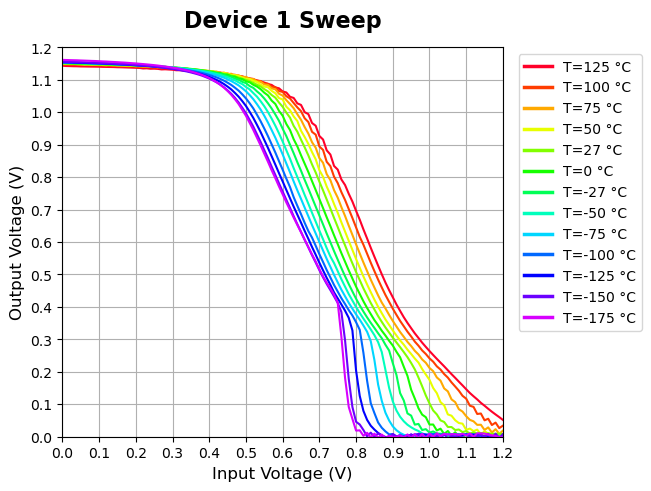

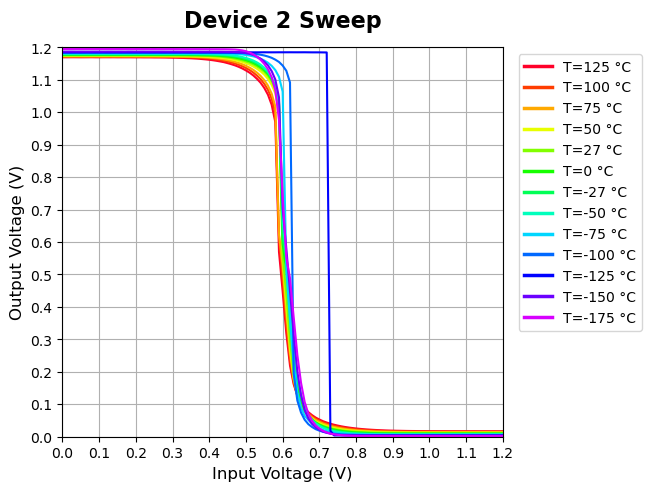

In [4]:
# Create directory
DATE="Omar_Testing_Results/"+str(date.today())     # Create a directory with the date. If the directory already exists, it won't raise an error due to exist_ok=True
os.makedirs(DATE, exist_ok=True)
i=1
DUT= str(DATE)+"/DUT_"+str(i)
while os.path.isdir(DUT) == True and len(os.listdir(DUT)) != 0 :               # Keeps track of the number of tests done today and checks if the folder is empty
    DUT= str(DATE)+"/DUT_"+str(i)                
    i=i+1
os.makedirs(DUT, exist_ok=True)                 # Create another directory for test date for this test



################## Initial creation and format of overall IV curves ##################
# Create a color map for the plots
cm=plt.get_cmap('gist_rainbow')

# Create a figure for the overall Vout plot for the 1st Device
M1fig, M1plot = plt.subplots(layout='constrained')
M1plot.set_title('Device 1 Sweep', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
M1plot.set_xlabel('Input Voltage (V)', fontdict={'fontsize': 12})
M1plot.set_ylabel('Output Voltage (V)', fontdict={'fontsize': 12})
M1plot.set_yticks(np.arange(0, 1.3, 0.1))
M1plot.set_xticks(np.arange(0, 1.3, 0.1))
M1plot.tick_params(axis='both', which='major', labelsize=10)
M1plot.set_prop_cycle ('color', [cm(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
M1plot.set_xlim(0, 1.2)
M1plot.set_ylim(0, 1.2)
M1plot.grid()

# Create a figure for the overall Vout plot for the 2nd Device
M2fig, M2plot = plt.subplots(layout='constrained')
M2plot.set_title('Device 2 Sweep', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
M2plot.set_xlabel('Input Voltage (V)', fontdict={'fontsize': 12})
M2plot.set_ylabel('Output Voltage (V)', fontdict={'fontsize': 12})
M2plot.set_yticks(np.arange(0, 1.3, 0.1))
M2plot.set_xticks(np.arange(0, 1.3, 0.1))
M2plot.tick_params(axis='both', which='major', labelsize=10)
M2plot.set_prop_cycle ('color', [cm(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
M2plot.set_xlim(0, 1.2)
M2plot.set_ylim(0, 1.2)
M2plot.grid()


Chamber_INIT()
time.sleep(1)
SMUs_INIT()
MMs_INIT()
time.sleep(1)
SMUs_On()
time.sleep(1)


for TEMP in TEMPlist:
    local=str(DUT)+"/TEMP_"+str(TEMP)                          # The temperature of the experiment gets set as the sub directory name. DUT_"directory_name"/yyyy-mm-dd/TEMP_"TEMP"
    os.makedirs(local, exist_ok=True)                           # Create a directory with the given name. If the directory already exists, it won't raise an error due to exist_ok=True
    
    CHAMBER.write("WAIT=30")                                    # Resets the wait time of the temp chamber to 30 minutes so it doesn't time out mid test
    CHAMBER.write("SET=" + str(TEMP))
    # TODO: There is probably a better way to check for temperature settling and do wait time
    while (CHAMBER.query("STATUS?")[3] == 'N'):                 # Checks if the temperature chamber has arrived at TEMP yet or not
        time.sleep(15)
        print(CHAMBER.query("STATUS?"))  
    print(CHAMBER.query("STATUS?"))
    time.sleep(300)                                             # Soak time
    y1, y2 = test_sweep(TEMP, local)

    
    M1plot.plot(x, np.asarray(y1, dtype='float'), label="T=" + str(TEMP) + " °C")
    M2plot.plot(x, np.asarray(y2, dtype='float'), label="T=" + str(TEMP) + " °C")


for line in M1plot.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines():
    line.set_linewidth(2.5)
for line in M2plot.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines():
    line.set_linewidth(2.5)
M1fig.savefig(os.path.join(DUT, "Device_1_Sweep.png"))
M2fig.savefig(os.path.join(DUT, "Device_2_Sweep.png"))
    

CHAMBER.write("SET=30")                             # Sets the temperature back to room temp once test is complete                      
while (CHAMBER.query("STATUS?")[3] == 'N'):         # Checks if chamber has arrived at room temp
    time.sleep(15)
CHAMBER.write("STOP")                               # Once chamber is at room temp, chamber stops operation